Download BTC data from [yahoo](https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD)

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Semon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data loading

In [3]:
# ticker_df_path = 'data/DOGE-USD.csv'
ticker_df_path = 'data/BTC-USD.csv'
# ticker_df_path = 'data/TSLA.csv'
# ticker_df_path = 'data/CNY=X.csv'

tweets_df_path = 'data/elon_prepared_tweets.csv'
# tweets_df_path = 'data/trump_prepared_tweets.csv'

In [4]:
ticker_df = pd.read_csv(ticker_df_path)
ticker_df.Date = pd.to_datetime(ticker_df.Date)
ticker_df.set_index('Date', drop=True, inplace=True)
ticker_df['NextDayClose'] = ticker_df.Close.shift(-1)
ticker_df = ticker_df.reindex(
    pd.date_range(
        '2019-01-01', 
        ticker_df.index.max()
    ),
    method='backfill',
)
ticker_df.head()

,Open,High,Low,Close,Adj Close,Volume,NextDayClose
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09,3943.409424
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09,3836.741211
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09,3857.717529
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09,3845.194580
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09,4076.632568


In [5]:
ticker_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1323 entries, 2019-01-01 to 2022-08-15
Freq: D
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1322 non-null   float64
 1   High          1322 non-null   float64
 2   Low           1322 non-null   float64
 3   Close         1322 non-null   float64
 4   Adj Close     1322 non-null   float64
 5   Volume        1322 non-null   float64
 6   NextDayClose  1321 non-null   float64
dtypes: float64(7)
memory usage: 82.7 KB


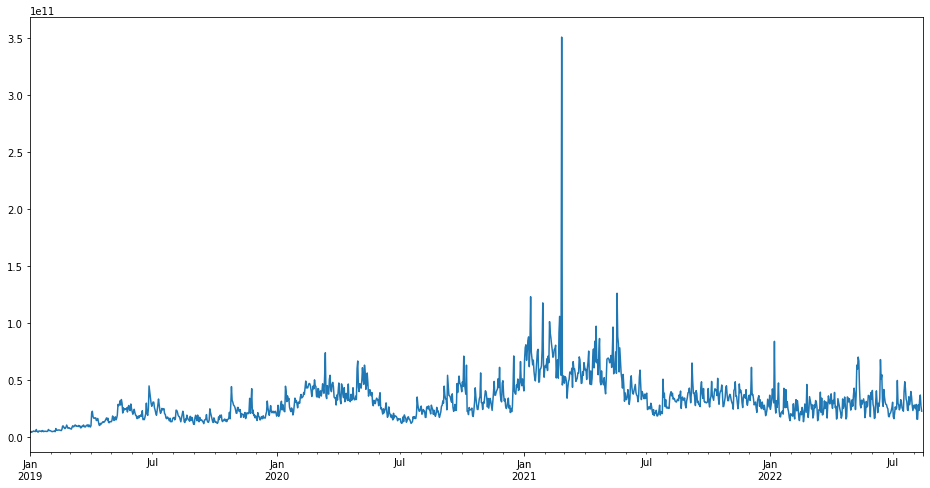

In [6]:
ticker_df.Volume.plot(figsize=(16, 8));

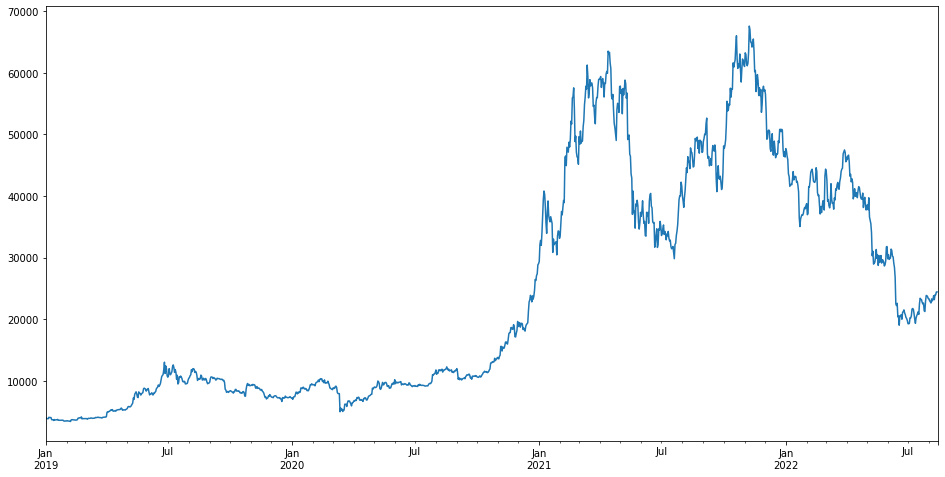

In [7]:
ticker_df.Close.plot(figsize=(16, 8));

In [8]:
tweets_df = pd.read_csv(tweets_df_path, index_col='id', parse_dates=['date'])
tweets_df.head()

,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300
id,,,,,,,,,,,,,,,,,,,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,this is a pretty awful lie i left south africa...,-0.048342,-0.014244,0.016088,0.002211,-0.012234,0.082633,-0.016118,...,-0.000773,-0.019107,-0.039366,0.015982,0.049104,-0.056251,-0.057072,-0.057435,-0.011789,0.036748
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,this person blocked me so can t read the tweet...,-0.012730,-0.017078,0.028585,0.025572,-0.045578,0.065623,-0.013617,...,-0.012550,-0.046741,-0.000691,0.019577,0.077184,-0.057226,-0.047901,0.028700,0.011547,0.033419
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,we started zip2 with 2k from me plus my overcl...,-0.042071,-0.075559,-0.029521,0.020394,-0.014714,0.073634,-0.013487,...,-0.022040,-0.001922,-0.011946,0.028490,0.086696,-0.028041,-0.038507,-0.005319,0.075069,-0.058273
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,he didn t own an emerald mine i worked my way ...,-0.026122,-0.068418,0.031035,-0.038473,-0.031547,0.080213,-0.034022,...,0.003521,-0.032675,-0.035726,-0.006440,0.051075,-0.005771,-0.002485,-0.073661,-0.000422,0.012104
1211051740562366464,@geofficient Pretty much,2019-12-28,pretty much,-0.061854,-0.111202,0.020066,0.037324,-0.120143,0.163722,-0.013768,...,0.025169,-0.046883,-0.015783,0.062415,0.068658,-0.104441,-0.167005,0.059559,0.263472,0.011272


In [9]:
# tweets_df = tweets_df[tweets_df.cleared_text.str.contains('doge')]

In [10]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8643 entries, 1211071324518531072 to 1344810193952014336
Columns: 303 entries, text to V300
dtypes: datetime64[ns](1), float64(300), object(2)
memory usage: 20.0+ MB


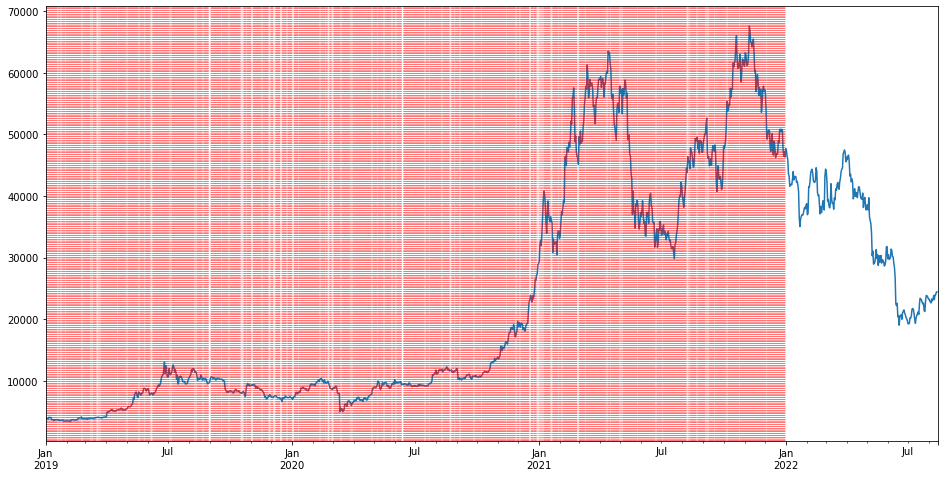

In [11]:
ticker_df.Close.plot(figsize=(16, 8));
for xc in set(tweets_df.date): # [tweets_df.cleared_text.str.contains('doge')]
    plt.axvline(x=xc, color='red', dashes=(0.2, 1))

In [12]:
tweets_df['ticker_grow_in_this_day'] = tweets_df.apply(
    lambda r: ticker_df.loc[r['date']], 
    axis=1
).apply(
    lambda r: np.int32(r.Open > r.NextDayClose), 
    axis=1
)

In [13]:
tweets_df['ticker_grow_in_this_day'].mean()

0.4275135948166146

In [14]:
tweets_df.head()

,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V292,V293,V294,V295,V296,V297,V298,V299,V300,ticker_grow_in_this_day
id,,,,,,,,,,,,,,,,,,,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,this is a pretty awful lie i left south africa...,-0.048342,-0.014244,0.016088,0.002211,-0.012234,0.082633,-0.016118,...,-0.019107,-0.039366,0.015982,0.049104,-0.056251,-0.057072,-0.057435,-0.011789,0.036748,0
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,this person blocked me so can t read the tweet...,-0.012730,-0.017078,0.028585,0.025572,-0.045578,0.065623,-0.013617,...,-0.046741,-0.000691,0.019577,0.077184,-0.057226,-0.047901,0.028700,0.011547,0.033419,0
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,we started zip2 with 2k from me plus my overcl...,-0.042071,-0.075559,-0.029521,0.020394,-0.014714,0.073634,-0.013487,...,-0.001922,-0.011946,0.028490,0.086696,-0.028041,-0.038507,-0.005319,0.075069,-0.058273,0
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,he didn t own an emerald mine i worked my way ...,-0.026122,-0.068418,0.031035,-0.038473,-0.031547,0.080213,-0.034022,...,-0.032675,-0.035726,-0.006440,0.051075,-0.005771,-0.002485,-0.073661,-0.000422,0.012104,0
1211051740562366464,@geofficient Pretty much,2019-12-28,pretty much,-0.061854,-0.111202,0.020066,0.037324,-0.120143,0.163722,-0.013768,...,-0.046883,-0.015783,0.062415,0.068658,-0.104441,-0.167005,0.059559,0.263472,0.011272,0


In [15]:
words_on_grow_df = pd.DataFrame({
    'words': tweets_df.cleared_text.str.split().apply(set),
    'ticker_grow_in_this_day': tweets_df.ticker_grow_in_this_day,
}).explode('words')

words_in_tweets = pd.DataFrame({
    'tweets_ratio': words_on_grow_df.groupby('words')['ticker_grow_in_this_day'].count() / len(tweets_df),
    'tweets_grow_ratio': (
        words_on_grow_df.query('ticker_grow_in_this_day == 1').groupby('words')['ticker_grow_in_this_day'].count() 
        / len(tweets_df.query('ticker_grow_in_this_day == 1'))
    ),
    'tweets_fall_ratio': (
        words_on_grow_df.query('ticker_grow_in_this_day == 0').groupby('words')['ticker_grow_in_this_day'].count() 
        / len(tweets_df.query('ticker_grow_in_this_day == 0'))
    ),
}).fillna(0).query('tweets_ratio > 0.001')
words_in_tweets['grow_delta'] = (words_in_tweets.tweets_grow_ratio - words_in_tweets.tweets_ratio) / words_in_tweets.tweets_ratio
words_in_tweets['fall_delta'] = (words_in_tweets.tweets_fall_ratio - words_in_tweets.tweets_ratio) / words_in_tweets.tweets_ratio

In [16]:
words_in_tweets.sort_values(by='grow_delta', ascending=False).head(10)

,tweets_ratio,tweets_grow_ratio,tweets_fall_ratio,grow_delta,fall_delta
words,,,,,
variant,0.001041,0.002165,0.000202,1.079206,-0.805915
school,0.001041,0.002165,0.000202,1.079206,-0.805915
saw,0.001041,0.002165,0.000202,1.079206,-0.805915
10x,0.001273,0.002436,0.000404,0.913815,-0.682406
vertical,0.001157,0.002165,0.000404,0.871286,-0.650647
aka,0.001157,0.002165,0.000404,0.871286,-0.650647
expansion,0.001157,0.002165,0.000404,0.871286,-0.650647
individual,0.001157,0.002165,0.000404,0.871286,-0.650647
ultra,0.001041,0.001894,0.000404,0.819305,-0.611830


In [17]:
words_in_tweets.sort_values(by='fall_delta', ascending=False).head(10)

,tweets_ratio,tweets_grow_ratio,tweets_fall_ratio,grow_delta,fall_delta
words,,,,,
opposite,0.001041,0.000000,0.001819,-1.000000,0.746766
choice,0.001736,0.000271,0.002829,-0.844060,0.630315
kids,0.001388,0.000271,0.002223,-0.805074,0.601203
capable,0.001273,0.000271,0.002021,-0.787354,0.587969
written,0.001273,0.000271,0.002021,-0.787354,0.587969
send,0.001157,0.000271,0.001819,-0.766089,0.572090
drivers,0.001041,0.000271,0.001617,-0.740099,0.552681
highest,0.001041,0.000271,0.001617,-0.740099,0.552681
understood,0.001041,0.000271,0.001617,-0.740099,0.552681


## TF-IDF. Logistic regression

In [18]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),
    max_features=500,
)

In [19]:
X = tfidf_vectorizer.fit_transform(tweets_df.cleared_text).toarray()
y = tweets_df.ticker_grow_in_this_day

len(tfidf_vectorizer.vocabulary_)

500

In [20]:
train_percent = 0.8
idx = int(train_percent * len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.9, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7778, 500), (865, 500), (7778,), (865,))

In [21]:
rnd = np.random.default_rng(42)

y_baseline = np.int32(rnd.random(y_test.shape) <= y.mean())
print('Test classification report (baseline):\n')
print(classification_report(y_true=y_test, y_pred=y_baseline))

Test classification report (baseline):

              precision    recall  f1-score   support

           0       0.56      0.56      0.56       495
           1       0.41      0.41      0.41       370

    accuracy                           0.50       865
   macro avg       0.48      0.48      0.48       865
weighted avg       0.50      0.50      0.50       865



In [22]:
%%time
lin_regr = LogisticRegressionCV(
    cv=5,
    max_iter=5000,
    random_state=42,
    # scoring=lambda y_true, y_pred, *args: precision_score(1 - y_true, 1 - y_pred, *args),
    # scoring='precision',
    # class_weight='balanced',
    # multi_class='ovr',
).fit(X_train, y_train)

CPU times: total: 33.5 s
Wall time: 6.82 s


In [23]:
y_train_pred = lin_regr.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73      4453
           1       0.00      0.00      0.00      3325

    accuracy                           0.57      7778
   macro avg       0.29      0.50      0.36      7778
weighted avg       0.33      0.57      0.42      7778



C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [24]:
y_pred = lin_regr.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       495
           1       0.00      0.00      0.00       370

    accuracy                           0.57       865
   macro avg       0.29      0.50      0.36       865
weighted avg       0.33      0.57      0.42       865



C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [25]:
words_coeffs = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    lin_regr.coef_.flatten()
)))

In [26]:
lin_regr.intercept_

array([-0.29206612])

In [27]:
words_coeffs.sort_values(ascending=False).head(15)

true          0.000799
like          0.000700
sigh          0.000530
cybertruck    0.000516
well          0.000507
actually      0.000483
love          0.000436
even          0.000430
awesome       0.000373
exactly       0.000369
new           0.000345
around        0.000335
higher        0.000335
sorry         0.000334
wow           0.000334
dtype: float64

In [28]:
words_coeffs.sort_values(ascending=True).head(15)

good     -0.000951
great    -0.000670
also     -0.000634
time     -0.000529
yeah     -0.000449
cars     -0.000440
get      -0.000403
months   -0.000379
rocket   -0.000377
agreed   -0.000370
coming   -0.000365
video    -0.000361
feel     -0.000346
might    -0.000339
bad      -0.000331
dtype: float64

## TF-IDF. Random forest

In [29]:
random_forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [30]:
y_train_pred = random_forest.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      4453
           1       0.93      0.68      0.78      3325

    accuracy                           0.84      7778
   macro avg       0.86      0.82      0.83      7778
weighted avg       0.85      0.84      0.83      7778



In [31]:
y_pred = random_forest.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.58      0.77      0.66       495
           1       0.44      0.24      0.31       370

    accuracy                           0.55       865
   macro avg       0.51      0.51      0.49       865
weighted avg       0.52      0.55      0.51       865



In [32]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [33]:
%%time
CV_rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: total: 3.02 s
Wall time: 2min 53s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             scoring='accuracy', verbose=1)

In [34]:
y_train_pred = CV_rfc.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73      4453
           1       0.00      0.00      0.00      3325

    accuracy                           0.57      7778
   macro avg       0.29      0.50      0.36      7778
weighted avg       0.33      0.57      0.42      7778



C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [35]:
y_pred = CV_rfc.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       495
           1       0.00      0.00      0.00       370

    accuracy                           0.57       865
   macro avg       0.29      0.50      0.36       865
weighted avg       0.33      0.57      0.42       865



C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [36]:
words_importances = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    CV_rfc.best_estimator_.feature_importances_
)))

In [37]:
words_importances.sort_values(ascending=False).head(15)

like          0.020914
video         0.016446
public        0.012946
rocket        0.012794
needed        0.012528
ton           0.012316
actually      0.012311
goes          0.012242
higher        0.011336
production    0.011163
cybertruck    0.011130
well          0.011081
hard          0.010861
would         0.010669
even          0.010191
dtype: float64

In [38]:
words_importances.sort_values(ascending=True).head(15)

used           0.0
future         0.0
internal       0.0
everyone       0.0
half           0.0
since          0.0
center         0.0
interesting    0.0
called         0.0
come           0.0
buy            0.0
building       0.0
bought         0.0
show           0.0
boca           0.0
dtype: float64